In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
import plotly
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yfinance as yf

In [2]:
# Importation des données du Bitcoin
btc_hist_data = yf.download('BTC-USD', period='max')

btc_hist_data.index = pd.to_datetime(btc_hist_data.index, unit='s')


# Séparation du target avec les autres caractéristiques
target_btc = btc_hist_data['Close']

btc_hist = btc_hist_data.drop(['Close'], axis=1)

target_column = "Close"

btc_hist.head(5)


[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-02-10  47153.527344  48146.171875  46905.320312  47771.277344   
2024-02-11  47768.968750  48535.937500  47617.406250  48293.917969   
2024-02-12  48296.386719  50280.476562  47745.761719  49958.222656   
2024-02-13  49941.359375  50358.390625  48406.496094  49742.441406   
2024-02-14  49733.445312  51953.660156  49343.679688  51512.433594   

               Adj Close       Volume  
Date                                   
2014-09-1

,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [21]:
btc_hist_data.isna().sum().sum()

0

In [4]:
# Fonction de division du dataset en données de test et données d'entrainement
def t_t_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = t_t_split(btc_hist_data, test_size=0.2)

# Forcer le maintien de la division du datastet à chaquue exécution
seeds = 58

# test_size=  0.2
# # train et test split
# btc_train, btc_test, target_train, target_test = train_test_split(
#         btc_hist, target_btc,
#         test_size=0.2,
#         random_state=seeds
#     )



# # Train et test du datframe initial
# def t_t_split(df, test_size, seeds):
#     btc_train, btc_test,d,f = train_test_split(df,df, test_size=test_size, random_state=seeds)
#     return btc_train, btc_test
# train, test = t_t_split(btc_hist_data, test_size,seeds)


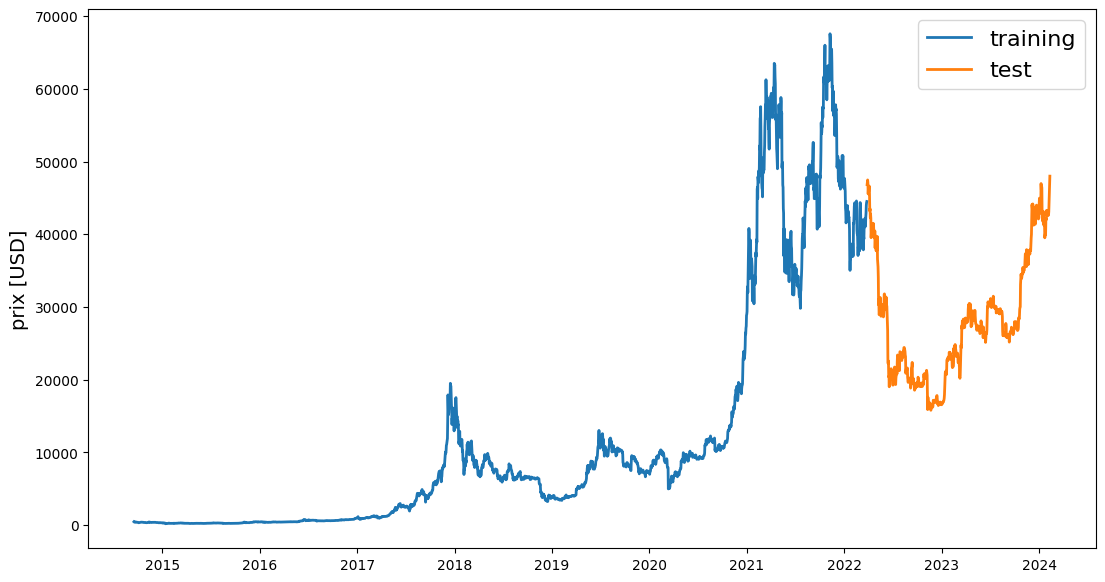

In [98]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_column], test[target_column], 'training', 'test', title='')

In [11]:
def normaliser_zero_base(dataframe):
    return dataframe / dataframe.iloc[0] - 1

# Noramliser les données en utilisant le MinMax
def normaliser_min_max(dataframe):
    return (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())


# Extraire des fenêtres de données de taille 5
def extract_window_data(dataframe, window_lenght=5, zero_base=True):
    window_data = []
    for index in range(len(dataframe) - window_lenght):
        temp_save = dataframe[index: (index + window_lenght)].copy()
        if zero_base:
            temp_save = normaliser_zero_base(temp_save)
        window_data.append(temp_save.values)
    return np.array(window_data)

# # Noramlisation
# scaler = StandardScaler()
# btc_hist_normalised = scaler.fit_transform(btc_hist)

# print(btc_hist_normalised.mean())
# print(btc_hist_normalised.std())

# btc_hist_normalised
# ff = (btc_hist - btc_hist.mean())
# tt = btc_hist.std()
# ff = ff/tt
# print(ff.head(5))
# print(ff.mean())

# # Noramlisation avec MinMaxScaler
# min_max_scaler = MinMaxScaler()
# btc_hist_min_max_norm = min_max_scaler.fit_transform(btc_hist)
# print(btc_hist_min_max_norm)

In [7]:
# La préparation des données 
def prepare_data(btc_hist, target_btc, target_column, window_len=10, zero_base=True):
    train_data, test_data = btc_hist, target_btc
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_column][window_len:].values
    y_test = test_data[target_column][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[target_column][:-window_len].values - 1
        y_test = y_test / test_data[target_column][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test


In [18]:
temp_save = btc_hist_data[1: (1 + 5)].copy()

temp_save

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600


In [34]:
#La construction du modèle en LSTM
def lstm_model_building(input_data, output_size, neurons=300, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons,  input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# btc_train.shape[1]

In [35]:
# Les informations desquelles nous nous servirions pour l'utilisation du modèle
np.random.seed(seeds)
window_len = 7
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [36]:
# Utilisation des fonctions de séparation des données
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(train, test, target_column, window_len=window_len, zero_base=True)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=seeds)

# Utilisation du modèle de prédiction construit
model = lstm_model_building(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

# Entrainement du modèle proprement dit
btc_history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_data=(X_val, y_val))

Epoch 1/100
69/69 [==============================] - 4s 17ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 2/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/100
69/69 [==============================] - 1s 17ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0019
Epoc

2883.6

(2751, 6) (687, 6) (2195, 7, 6) (680, 7, 6) (2195,) (680,)


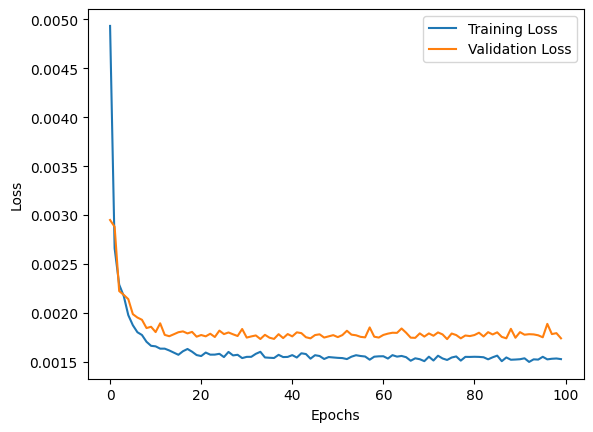

NameError: name 'history' is not defined

In [55]:
print(train_data.shape, test_data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape )
# Afficher la courbe de la perte
plt.plot(btc_history.history['loss'], label='Training Loss')
plt.plot(btc_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [46]:
targets = test[target_column][window_len:]
targets =  pd.DataFrame({
    f"{target_column}" : targets
})
preds = model.predict(X_test).squeeze()
print("Moyenne de l'errreur absolue", mean_absolute_error(preds, y_test))
print(targets)


22/22 [==============================] - 0s 4ms/step
Moyenne de l'errreur absolue 0.019317399269275323
                   Close
Date                    
2022-04-06  43206.738281
2022-04-07  43503.847656
2022-04-08  42287.664062
2022-04-09  42782.136719
2022-04-10  42207.671875
...                  ...
2024-02-10  47771.277344
2024-02-11  48293.917969
2024-02-12  49958.222656
2024-02-13  49742.441406
2024-02-14  51512.433594

[680 rows x 1 columns]


In [47]:
# Obtention de la moyenne des prédictions effectuées (des valeurs normées)
mean_preds = (np.mean(preds))
mean_preds

0.0071781524

In [48]:
# print(test[target_column].values[:-window_len] * (preds + 1))
preds = test[target_column].values[:-window_len] * (preds + 1)

preds = pd.DataFrame(
    data = {f'{target_column}':preds}, 
    index= targets.index
)


print(preds)
# line_plot(targets, preds[target_column], 'Valeurs réelles', 'prediction', lw=3)

                   Close
Date                    
2022-04-06  45654.258267
2022-04-07  43397.443707
2022-04-08  43513.551203
2022-04-09  42357.456653
2022-04-10  42525.849842
...                  ...
2024-02-10  47817.237028
2024-02-11  48081.075298
2024-02-12  48775.161275
2024-02-13  50063.055923
2024-02-14  50085.217938

[680 rows x 1 columns]


In [56]:
# Créez un DataFrame avec ces deux séries en tant que colonnes
data = {'Valeurs exactes': targets[target_column], 'Valeurs prédites': preds[target_column]}
compare = pd.DataFrame(data, index=targets.index)

# Affichez le DataFrame
print(compare)

            Valeurs exactes  Valeurs prédites
Date                                         
2022-04-06     43206.738281      45654.258267
2022-04-07     43503.847656      43397.443707
2022-04-08     42287.664062      43513.551203
2022-04-09     42782.136719      42357.456653
2022-04-10     42207.671875      42525.849842
...                     ...               ...
2024-02-10     47771.277344      47817.237028
2024-02-11     48293.917969      48081.075298
2024-02-12     49958.222656      48775.161275
2024-02-13     49742.441406      50063.055923
2024-02-14     51512.433594      50085.217938

[680 rows x 2 columns]


In [57]:
# Prédire pour plusieurs jours à venir
num_days_to_predict = 7
 
# Création d'un dataframe qui contiendra Les valeurs fictives prédites et leurs dates correspondantes
predicted_values_close = pd.DataFrame({})
future_dates = pd.date_range(btc_hist_data.index[-1], periods=num_days_to_predict+1, freq='D')[1:]  # Génération des dates futures
future_dates = pd.to_datetime(future_dates)
btc_change = btc_hist_data
# Génération des valeurs fictives de 7 prochains jours
for future_date in future_dates:
    
    future_data = pd.DataFrame({'Open': np.mean(btc_change.iloc[-num_days_to_predict:]['Open']) * (mean_preds+1), 'High': np.mean(btc_change.iloc[-num_days_to_predict:]['High']) * (mean_preds+1), 'Low': np.mean(btc_change.iloc[-num_days_to_predict:]['Low']) * (mean_preds+1), 'Close': np.mean(btc_change.iloc[-num_days_to_predict:]['Close']) * (mean_preds+1), 'Adj Close': np.mean(btc_change.iloc[-num_days_to_predict:]['Adj Close']) * (mean_preds+1), 'Volume': np.mean(btc_change.iloc[-num_days_to_predict:]['Volume']) * (mean_preds+1)}, index=[future_date])
    btc_change = pd.concat((btc_change, future_data), axis=0)

(1, 6)

In [58]:
# Séparation du nouveau dataset en données d'entrainement et de test

train_btc, test_btc = t_t_split(btc_change, test_size=0.2)
test_btc.tail(7)

,Open,High,Low,Close,Adj Close,Volume
2024-02-15,47844.299643,49352.157183,47425.373670,48880.810173,48880.810173,3.037086e+10
2024-02-16,48349.640438,49895.503515,47870.438310,49395.801048,49395.801048,3.097751e+10
2024-02-17,48788.807181,50146.291943,48245.916353,49719.335710,49719.335710,2.977764e+10
2024-02-18,49024.095484,50434.074405,48438.804787,49999.627399,49999.627399,3.170264e+10
2024-02-19,49204.686373,50707.183265,48556.989739,50245.049296,50245.049296,3.348488e+10
2024-02-20,49335.374883,50768.578932,48673.711330,50286.318656,50286.318656,3.333710e+10
2024-02-21,49248.184263,50827.597889,48712.158951,50364.573125,50364.573125,3.301250e+10


In [59]:
# Divsion (de train et test) en données d'entrainement et de test
train_btc_data, test_btc_data, X_btc_train, X_btc_test, y_btc_train, y_btc_test = prepare_data(train_btc, test_btc, target_column, window_len=window_len, zero_base=True)
X_btc_train, X_btc_val, y_btc_train, y_btc_val= train_test_split(X_btc_train, y_btc_train, test_size=0.2, random_state=seeds)
print(y_train.shape)

(2195,)


In [60]:
# Sélection et formation des données des valeurs de la caractéristique cible
targets_btc = test_btc[target_column][window_len:]
targets_btc =  pd.DataFrame({
    f"{target_column}" : targets_btc
})

# Prédiction de données de test
preds_btc = model.predict(X_btc_test).squeeze()

# La moyenne de l'erreur absolue entre les données prédites et le données réelles
print("Moyenne de l'errreur absolue", mean_absolute_error(preds_btc, y_btc_test))
print(targets_btc)


# Dénormalisation des données des valeurs prédites
preds_btc = test_btc[target_column].values[:-window_len] * (preds_btc + 1)

# Création d'un dataframe basé sur les données prédites
preds_btc = pd.DataFrame(
    data = {f'{target_column}':preds_btc}, 
    index= targets_btc.index
)


print(preds_btc)



# Fusion  de deux dataframes (target_btc et preds_btc)
data_btc = {'Valeurs exactes': targets_btc[target_column], 'Valeurs prédites': preds_btc[target_column]}
compare_btc = pd.DataFrame(data_btc, index=targets_btc.index)

# Affichez le DataFrame
print(compare_btc)

22/22 [==============================] - 2s 14ms/step
Moyenne de l'errreur absolue 0.01924008448272413
                   Close
2022-04-11  39521.902344
2022-04-12  40127.183594
2022-04-13  41166.730469
2022-04-14  39935.515625
2022-04-15  40553.464844
...                  ...
2024-02-17  49719.335710
2024-02-18  49999.627399
2024-02-19  50245.049296
2024-02-20  50286.318656
2024-02-21  50364.573125

[682 rows x 1 columns]
                   Close
2022-04-11  42117.155306
2022-04-12  39472.723109
2022-04-13  40160.654806
2022-04-14  41290.845764
2022-04-15  40118.740885
...                  ...
2024-02-17  49898.795911
2024-02-18  49976.517779
2024-02-19  50191.766970
2024-02-20  50467.461436
2024-02-21  50420.910325

[682 rows x 1 columns]
            Valeurs exactes  Valeurs prédites
2022-04-11     39521.902344      42117.155306
2022-04-12     40127.183594      39472.723109
2022-04-13     41166.730469      40160.654806
2022-04-14     39935.515625      41290.845764
2022-04-15     4055

In [66]:
# La visualisation des données (réelles et prédites) de 8 derniers jours
compare_btc.tail(8)

,Valeurs exactes,Valeurs prédites
2024-02-14,51512.433594,50085.217938
2024-02-15,48880.810173,51899.001025
2024-02-16,49395.801048,49104.318137
2024-02-17,49719.335710,49898.795911
2024-02-18,49999.627399,49976.517779
2024-02-19,50245.049296,50191.766970
2024-02-20,50286.318656,50467.461436
2024-02-21,50364.573125,50420.910325


In [62]:
btc_change['Close'].tail(8)

2024-02-14    51512.433594
2024-02-15    48880.810173
2024-02-16    49395.801048
2024-02-17    49719.335710
2024-02-18    49999.627399
2024-02-19    50245.049296
2024-02-20    50286.318656
2024-02-21    50364.573125
Name: Close, dtype: float64

In [63]:
other_test = btc_change.iloc[-7:-1][target_column]

print(other_test)



2024-02-15    48880.810173
2024-02-16    49395.801048
2024-02-17    49719.335710
2024-02-18    49999.627399
2024-02-19    50245.049296
2024-02-20    50286.318656
Name: Close, dtype: float64


In [65]:
preds.index


DatetimeIndex(['2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09',
               '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15',
               ...
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12',
               '2024-02-13', '2024-02-14'],
              dtype='datetime64[ns]', name='Date', length=680, freq=None)

In [64]:
compare.head(10)

,Valeurs exactes,Valeurs prédites
Date,,
2022-04-06,43206.738281,45654.258267
2022-04-07,43503.847656,43397.443707
2022-04-08,42287.664062,43513.551203
2022-04-09,42782.136719,42357.456653
2022-04-10,42207.671875,42525.849842
2022-04-11,39521.902344,42117.155306
2022-04-12,40127.183594,39472.723109
2022-04-13,41166.730469,40160.654806
2022-04-14,39935.515625,41290.845764


In [118]:
compare.describe()

,Valeurs exactes,Valeurs prédites
count,681.000000,681.000000
mean,27726.642440,27722.153630
std,8017.108676,8009.721495
min,15787.284180,15728.529313
25%,21161.519531,21157.747050
50%,26861.707031,26827.166356
75%,30425.857422,30493.550529
max,47986.597656,47606.109645


In [119]:
print(model.predict(X_test))

22/22 [==============================] - 0s 3ms/step
[[-2.43065730e-02]
 [-1.94495730e-02]
 [-3.52787785e-02]
 [-1.66424289e-02]
 [ 2.30282042e-02]
 [-2.06807368e-02]
 [-5.74101508e-02]
 [-6.79756403e-02]
 [-9.03084204e-02]
 [-6.36753142e-02]
 [-3.09033468e-02]
 [-9.14351866e-02]
 [-5.29951677e-02]
 [-3.26373391e-02]
 [-4.49373536e-02]
 [ 2.18917727e-02]
 [-4.54957597e-04]
 [-4.10210565e-02]
 [ 2.12630220e-02]
 [ 2.54377034e-02]
 [ 3.20109203e-02]
 [ 2.51275226e-02]
 [-2.71948613e-02]
 [-5.25671914e-02]
 [-4.74058799e-02]
 [-8.50424077e-03]
 [-3.42381559e-02]
 [-2.22398248e-03]
 [ 1.21408794e-02]
 [-4.66247499e-02]
 [-1.04011772e-02]
 [-1.87337101e-02]
 [-3.49553078e-02]
 [-2.43481547e-02]
 [ 5.65611422e-02]
 [-5.04010022e-02]
 [-6.93233684e-02]
 [-6.93859458e-02]
 [-1.24330290e-01]
 [-1.42489254e-01]
 [-1.33038521e-01]
 [-1.40902147e-01]
 [-1.30648211e-01]
 [-4.53151911e-02]
 [-3.68945226e-02]
 [ 6.41093478e-02]
 [ 1.73262525e-02]
 [ 2.56777722e-02]
 [-4.92574945e-02]
 [-2.51226462e-0

## Enregistrement du modèle


In [120]:
# Enregistrement du modèle de machine learning (deep learning avec le réseau LSTM)

# Importation de la bibliothèque python permettant d'enregistrer des modèles et fonctions de python
import joblib
crypto_predict = model
joblib.dump(crypto_predict, "crypto_course.joblib")

['crypto_course.joblib']

In [133]:
# Enregistrement du dataset des données historiques du cours du Bitcoin et celui des prédictions du cours du Bitcoin

# Dataset des données prédites
def predict_data(preds_btc):
    preds_btc = preds_btc
    return preds_btc

# Dataset des données historiques  en USD
def btc_data():
    return btc_hist_data

# Dataset des prédictions de 7 prochains jours généré par notre nouveau modèle
def btc_data_preds(preds):
    btc_d = pd.DataFrame(preds.iloc[-num_days_to_predict:])
    return btc_d
   
predict_data = predict_data(preds_btc)
btc_data = btc_data()
btc_data_preds = btc_data_preds(btc_change)

# Enregistrement avec joblib
joblib.dump(btc_data_preds, "btc_data_preds.joblib")
joblib.dump(predict_data, "prediction.joblib")
joblib.dump(btc_data, "btc_dataset.joblib")

['btc_dataset.joblib']

In [132]:
# Vérification des données prédites
btc_data_preds(btc_change)

,Open,High,Low,Close,Adj Close,Volume
2024-02-11,43078.489689,43882.821149,42315.478246,43164.108601,43164.108601,2.401434e+10
2024-02-12,43079.357015,43896.545791,42326.225105,43185.418145,43185.418145,2.408987e+10
2024-02-13,43099.065588,43917.807855,42336.637087,43201.737601,43201.737601,2.425738e+10
2024-02-14,43113.963463,43944.710187,42354.972833,43233.452411,43233.452411,2.438822e+10
2024-02-15,43144.447138,43965.848173,42386.474288,43243.981813,43243.981813,2.437378e+10
2024-02-16,43153.129698,43976.405852,42396.144386,43260.787305,43260.787305,2.439454e+10
2024-02-17,43168.526025,43971.240877,42399.119416,43254.029184,43254.029184,2.433456e+10


In [ ]:
# Données historiques du Bitcoin en EURO
btc_hist_data_euro = yf.download('BTC-EUR', period='max')

# Dataset des données historiques en Euro
def btc_data_eur():
    return btc_hist_data_euro

btc_data_eur = btc_data_eur()

joblib.dump(btc_data_eur, "btc_dataset.joblib")